# Player Video Performance 

# 0. Install and Import Dependencies

In [2]:
import cv2
import mediapipe as mp
import numpy as np
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

In [3]:
from ultralytics import YOLO
# Load the YOLO11 model
model = YOLO("yolo11n.pt") 

In [4]:
# VIDEO FEED
cap = cv2.VideoCapture('FOOTBALL SKILLS.mp4')
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Fin de la vidéo ou erreur de lecture.")
        break
    cv2.imshow('Mediapipe Feed', frame)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

Fin de la vidéo ou erreur de lecture.


# 1. Make Detections

<img src="https://i.imgur.com/3j8BPdc.png" style="height:300px" >

# Football Skill Analysis: Pose Estimation and Ball Detection with YOLO and MediaPipe

In [6]:
import cv2
import numpy as np
import mediapipe as mp
from ultralytics import YOLO

# Charger YOLOv11
model = YOLO('yolo11n.pt')  # Assure-toi que ce fichier est bien dans le dossier

# Initialiser MediaPipe pose
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# Ouvrir la vidéo
cap = cv2.VideoCapture('FOOTBALL SKILLS.mp4')
if not cap.isOpened():
    print("❌ Erreur : Impossible d'ouvrir la vidéo.")
    exit()

# Définir une taille d'affichage (optionnel mais utile pour debug)
DISPLAY_WIDTH = 400

# Variable pour garder la position du sol
last_floor_y = None

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("✅ Fin de la vidéo ou erreur de lecture.")
            break

        # Redimensionner pour éviter un trop grand affichage
        scale_factor = DISPLAY_WIDTH / frame.shape[1]
        frame = cv2.resize(frame, None, fx=scale_factor, fy=scale_factor)
        height, width = frame.shape[:2]

        # -------- MediaPipe Pose --------
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image_rgb.flags.writeable = False
        results = pose.process(image_rgb)
        image_rgb.flags.writeable = True
        image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)

        # -------- Détection du sol --------
        if results.pose_landmarks:
            # Dessiner les landmarks du corps avec la couleur demandée
            mp_drawing.draw_landmarks(
                image_bgr, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(255,0,0), thickness=2, circle_radius=2),  # Points du corps
                mp_drawing.DrawingSpec(color=(255, 255, 0), thickness=2, circle_radius=2)   # Lignes de connexion
            )

            # Obtenir les points des pieds (talons et pointes)
            landmarks = results.pose_landmarks.landmark
            left_heel = landmarks[mp_pose.PoseLandmark.LEFT_HEEL]
            right_heel = landmarks[mp_pose.PoseLandmark.RIGHT_HEEL]
            left_foot_index = landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX]
            right_foot_index = landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX]

            # Convertir les coordonnées normalisées en pixels
            def get_pixel_coords(landmark):
                return int(landmark.x * width), int(landmark.y * height)

            left_heel_px = get_pixel_coords(left_heel)
            right_heel_px = get_pixel_coords(right_heel)
            left_foot_px = get_pixel_coords(left_foot_index)
            right_foot_px = get_pixel_coords(right_foot_index)

            # Estimer la position du sol comme le point le plus bas des pieds
            floor_y = max(left_heel_px[1], right_heel_px[1], left_foot_px[1], right_foot_px[1])

            # Si la personne est en l'air (vérifier la différence entre la position actuelle et la précédente)
            if last_floor_y is not None and abs(floor_y - last_floor_y) > 10:  # Seuil de mouvement
                # La personne pourrait être en l'air
                cv2.putText(image_bgr, "Jumping...", (10, floor_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)
            else:
                # Sinon, considérer la position comme un sol valide
                cv2.line(image_bgr, (0, floor_y), (width, floor_y), (0, 255, 255), 2)
                cv2.putText(image_bgr, "Floor", (10, floor_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)

            # Mémoriser la position du sol pour la prochaine itération
            last_floor_y = floor_y

        # -------- YOLOv11 Ball Detection --------
        detections = model.predict(frame, conf=0.3, verbose=False)

        for r in detections:
            for box in r.boxes:
                cls_id = int(box.cls[0])
                label = r.names[cls_id]

                # Remplacer le label 'sports ball' par 'Ball'
                if label.lower() == 'sports ball':
                    label = 'Ball'

                if label.lower() == 'ball':  # On garde le contrôle ici
                    x1, y1, x2, y2 = map(int, box.xyxy[0])

                    # Calculer le centre de la balle
                    center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2
                    radius = (x2 - x1) // 2

                    # Dessiner un cercle autour de la balle
                    cv2.circle(image_bgr, (center_x, center_y), radius, (0, 255, 0), 2)
                    # Dessiner un point au centre de la balle avec la couleur demandée
                    cv2.circle(image_bgr, (center_x, center_y), 5, (255,0,0), -1)  # Point au centre de la balle
                    cv2.putText(image_bgr, label, (x1, y1 - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

                    # Calculer la distance entre la balle et le sol (si le sol est détecté)
                    if last_floor_y is not None:
                        distance_to_floor = center_y - last_floor_y
                        cv2.putText(image_bgr, f"Height: {abs(distance_to_floor)}px", 
                                    (center_x - 30, center_y - 20), 
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)


        # Affichage
        cv2.imshow('⚽ Football Performances', image_bgr)

        # Vérifier si l'utilisateur appuie sur 'q' ou 'ESC' pour quitter
        key = cv2.waitKey(1)
        if key == ord('q') or key == 27:
            break

# Libérer la vidéo et fermer les fenêtres correctement
cap.release()
cv2.destroyAllWindows()


✅ Fin de la vidéo ou erreur de lecture.


✅ Fin de la vidéo ou erreur de lecture.


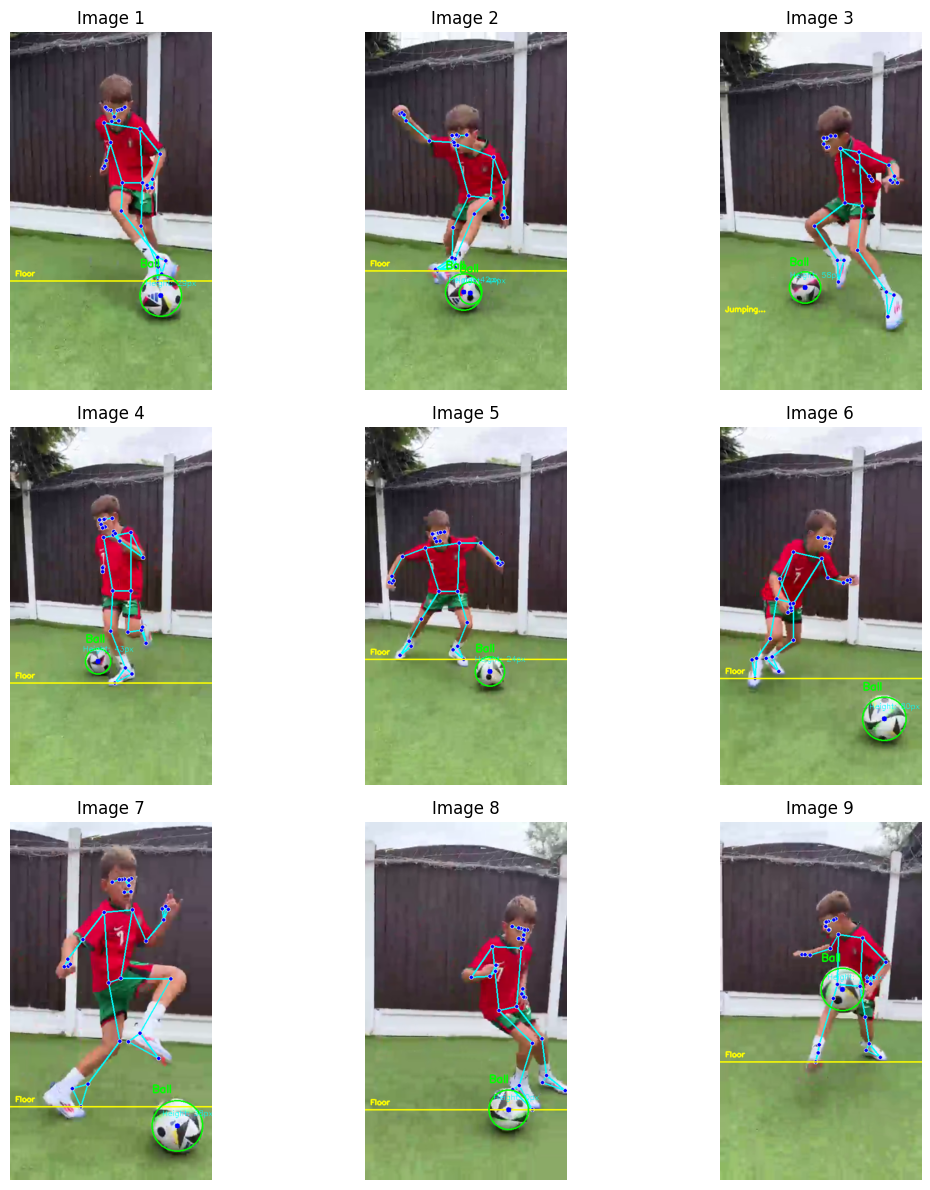

In [2]:
import cv2
import numpy as np
import mediapipe as mp
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Charger YOLOv11
model = YOLO('yolo11n.pt')  # Assure-toi que ce fichier est bien dans le dossier

# Initialiser MediaPipe pose
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# Ouvrir la vidéo
cap = cv2.VideoCapture('FOOTBALL SKILLS.mp4')
if not cap.isOpened():
    print("❌ Erreur : Impossible d'ouvrir la vidéo.")
    exit()

# Définir une taille d'affichage (optionnel mais utile pour debug)
DISPLAY_WIDTH = 400

# Liste pour stocker les frames détectées
frames = []

# Variable pour garder la position du sol
last_floor_y = None

frame_counter = 0  # Compteur pour les frames

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("✅ Fin de la vidéo ou erreur de lecture.")
            break

        frame_counter += 1

        # Redimensionner pour éviter un trop grand affichage
        scale_factor = DISPLAY_WIDTH / frame.shape[1]
        frame = cv2.resize(frame, None, fx=scale_factor, fy=scale_factor)
        height, width = frame.shape[:2]

        # -------- MediaPipe Pose --------
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image_rgb.flags.writeable = False
        results = pose.process(image_rgb)
        image_rgb.flags.writeable = True
        image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)

        # -------- Détection du sol --------
        if results.pose_landmarks:
            # Dessiner les landmarks du corps avec la couleur demandée
            mp_drawing.draw_landmarks(
                image_bgr, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(255,0,0), thickness=2, circle_radius=2),  # Points du corps
                mp_drawing.DrawingSpec(color=(255, 255, 0), thickness=2, circle_radius=2)   # Lignes de connexion
            )

            # Obtenir les points des pieds (talons et pointes)
            landmarks = results.pose_landmarks.landmark
            left_heel = landmarks[mp_pose.PoseLandmark.LEFT_HEEL]
            right_heel = landmarks[mp_pose.PoseLandmark.RIGHT_HEEL]
            left_foot_index = landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX]
            right_foot_index = landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX]

            # Convertir les coordonnées normalisées en pixels
            def get_pixel_coords(landmark):
                return int(landmark.x * width), int(landmark.y * height)

            left_heel_px = get_pixel_coords(left_heel)
            right_heel_px = get_pixel_coords(right_heel)
            left_foot_px = get_pixel_coords(left_foot_index)
            right_foot_px = get_pixel_coords(right_foot_index)

            # Estimer la position du sol comme le point le plus bas des pieds
            floor_y = max(left_heel_px[1], right_heel_px[1], left_foot_px[1], right_foot_px[1])

            # Si la personne est en l'air (vérifier la différence entre la position actuelle et la précédente)
            if last_floor_y is not None and abs(floor_y - last_floor_y) > 10:  # Seuil de mouvement
                # La personne pourrait être en l'air
                cv2.putText(image_bgr, "Jumping...", (10, floor_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)
            else:
                # Sinon, considérer la position comme un sol valide
                cv2.line(image_bgr, (0, floor_y), (width, floor_y), (0, 255, 255), 2)
                cv2.putText(image_bgr, "Floor", (10, floor_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)

            # Mémoriser la position du sol pour la prochaine itération
            last_floor_y = floor_y

        # -------- YOLOv11 Ball Detection --------
        detections = model.predict(frame, conf=0.3, verbose=False)

        for r in detections:
            for box in r.boxes:
                cls_id = int(box.cls[0])
                label = r.names[cls_id]

                # Remplacer le label 'sports ball' par 'Ball'
                if label.lower() == 'sports ball':
                    label = 'Ball'

                if label.lower() == 'ball':  # On garde le contrôle ici
                    x1, y1, x2, y2 = map(int, box.xyxy[0])

                    # Calculer le centre de la balle
                    center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2
                    radius = (x2 - x1) // 2

                    # Dessiner un cercle autour de la balle
                    cv2.circle(image_bgr, (center_x, center_y), radius, (0, 255, 0), 2)
                    # Dessiner un point au centre de la balle avec la couleur demandée
                    cv2.circle(image_bgr, (center_x, center_y), 5, (255,0,0), -1)  # Point au centre de la balle
                    cv2.putText(image_bgr, label, (x1, y1 - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

                    # Calculer la distance entre la balle et le sol (si le sol est détecté)
                    if last_floor_y is not None:
                        distance_to_floor = center_y - last_floor_y
                        cv2.putText(image_bgr, f"Height: {abs(distance_to_floor)}px", 
                                    (center_x - 30, center_y - 20), 
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)

        # Ajouter la frame à la liste tous les 10 frames
        if frame_counter % 10 == 0:
            frames.append(image_bgr)

        # Affichage
        cv2.imshow('⚽ Football Performances', image_bgr)

        # Vérifier si l'utilisateur appuie sur 'q' ou 'ESC' pour quitter
        key = cv2.waitKey(1)
        if key == ord('q') or key == 27:
            break

# Libérer la vidéo et fermer les fenêtres correctement
cap.release()
cv2.destroyAllWindows()

# Affichage des frames dans un grid après la fin de la vidéo
rows = 3  # Nombre de lignes dans la grille
cols = 3  # Nombre de colonnes dans la grille
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

for i in range(rows * cols):
    if i < len(frames):  # Assurez-vous qu'il y a assez de frames
        ax = axes[i // cols, i % cols]
        ax.imshow(cv2.cvtColor(frames[i], cv2.COLOR_BGR2RGB))
        ax.axis('off')
        ax.set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()


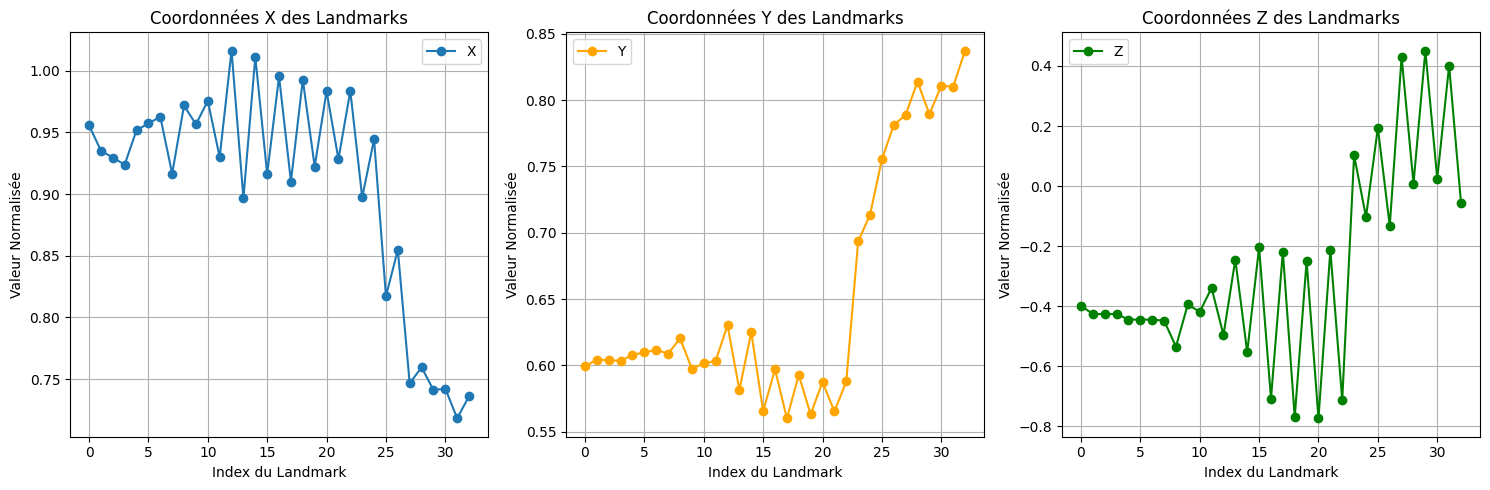

In [7]:
import matplotlib.pyplot as plt

# Vérifier si des landmarks sont disponibles
if landmarks:
    # Extraire les coordonnées x, y, z des landmarks
    x_coords = [landmark.x for landmark in landmarks]
    y_coords = [landmark.y for landmark in landmarks]
    z_coords = [landmark.z for landmark in landmarks]

    # Créer des graphes pour les coordonnées
    plt.figure(figsize=(15, 5))

    # Graphe des coordonnées X
    plt.subplot(1, 3, 1)
    plt.plot(range(len(x_coords)), x_coords, marker='o', label='X')
    plt.title('Coordonnées X des Landmarks')
    plt.xlabel('Index du Landmark')
    plt.ylabel('Valeur Normalisée')
    plt.grid(True)
    plt.legend()

    # Graphe des coordonnées Y
    plt.subplot(1, 3, 2)
    plt.plot(range(len(y_coords)), y_coords, marker='o', label='Y', color='orange')
    plt.title('Coordonnées Y des Landmarks')
    plt.xlabel('Index du Landmark')
    plt.ylabel('Valeur Normalisée')
    plt.grid(True)
    plt.legend()

    # Graphe des coordonnées Z
    plt.subplot(1, 3, 3)
    plt.plot(range(len(z_coords)), z_coords, marker='o', label='Z', color='green')
    plt.title('Coordonnées Z des Landmarks')
    plt.xlabel('Index du Landmark')
    plt.ylabel('Valeur Normalisée')
    plt.grid(True)
    plt.legend()

    # Afficher les graphes
    plt.tight_layout()
    plt.show()
else:
    print("Aucun landmark détecté.")

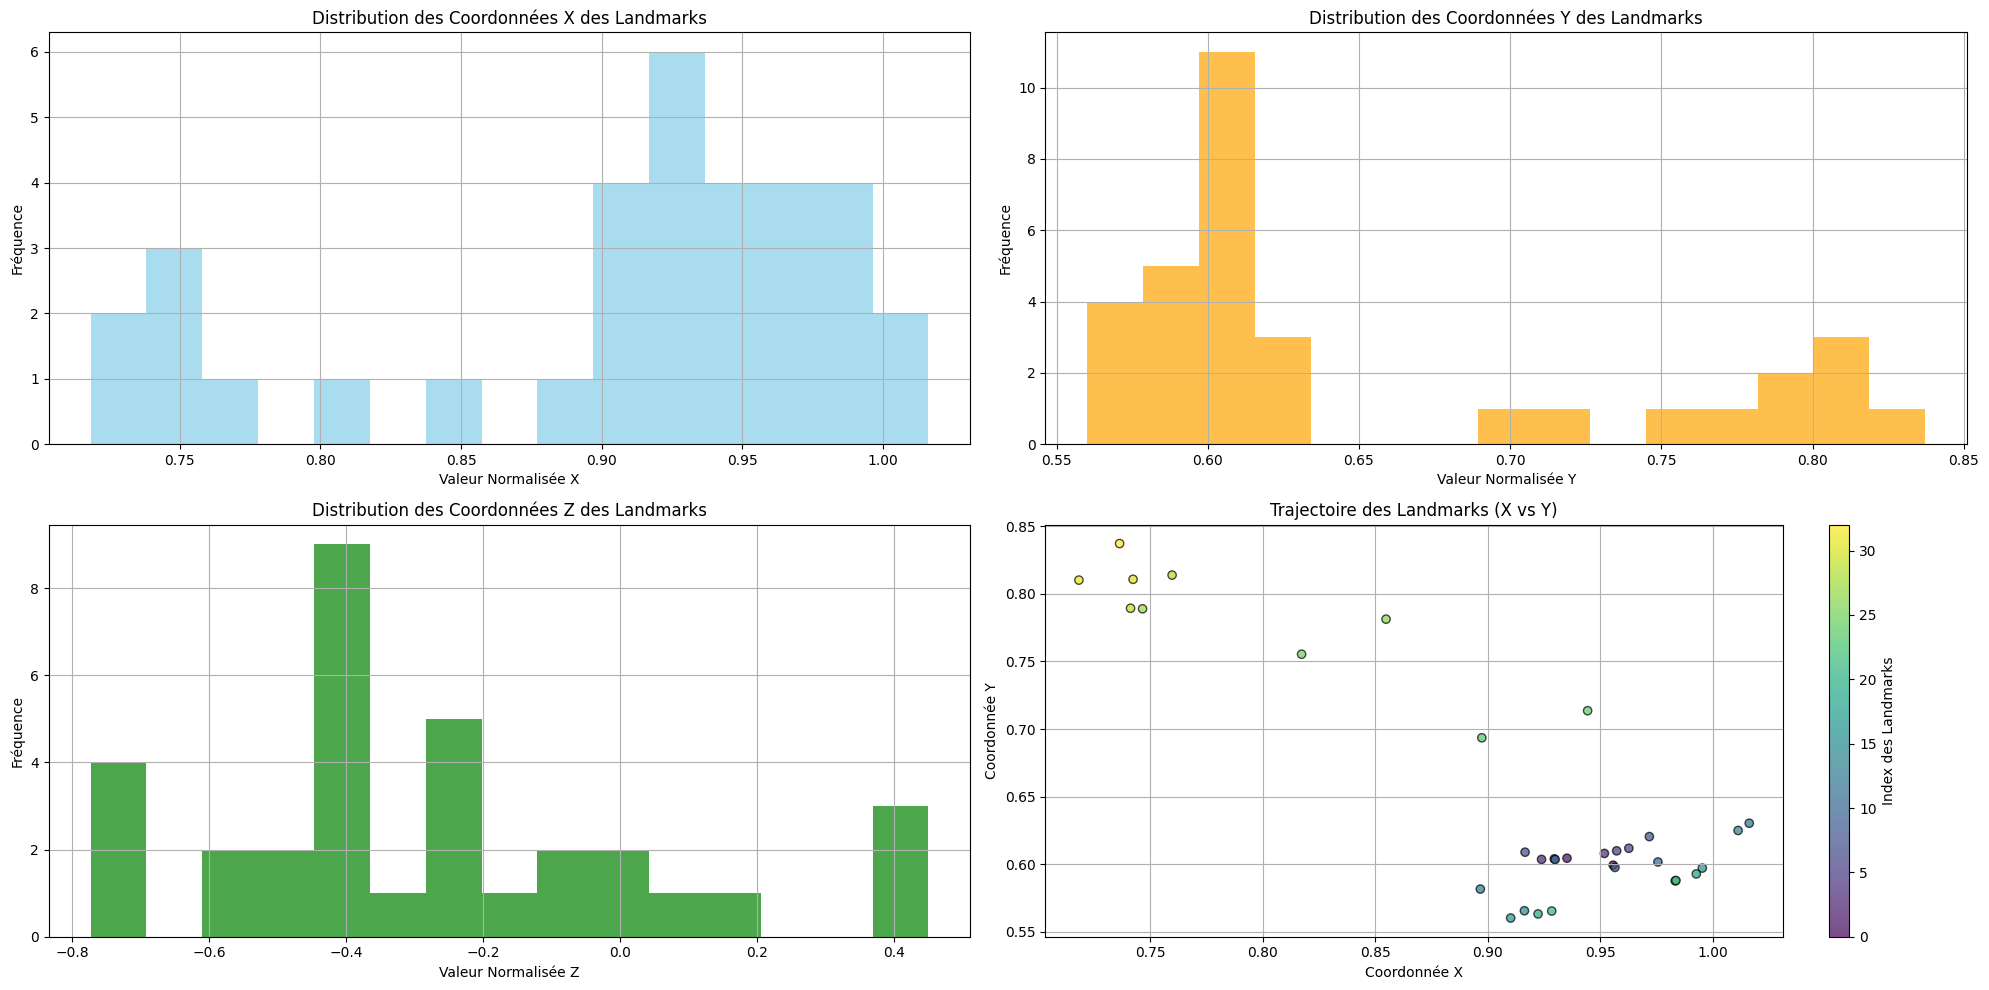

In [9]:
# Ajouter des visualisations supplémentaires
plt.figure(figsize=(20, 10))

# 1. Distribution des coordonnées X des landmarks
plt.subplot(2, 2, 1)
plt.hist(x_coords, bins=15, color='skyblue', alpha=0.7)
plt.title('Distribution des Coordonnées X des Landmarks')
plt.xlabel('Valeur Normalisée X')
plt.ylabel('Fréquence')
plt.grid(True)

# 2. Distribution des coordonnées Y des landmarks
plt.subplot(2, 2, 2)
plt.hist(y_coords, bins=15, color='orange', alpha=0.7)
plt.title('Distribution des Coordonnées Y des Landmarks')
plt.xlabel('Valeur Normalisée Y')
plt.ylabel('Fréquence')
plt.grid(True)

# 3. Distribution des coordonnées Z des landmarks
plt.subplot(2, 2, 3)
plt.hist(z_coords, bins=15, color='green', alpha=0.7)
plt.title('Distribution des Coordonnées Z des Landmarks')
plt.xlabel('Valeur Normalisée Z')
plt.ylabel('Fréquence')
plt.grid(True)

# 4. Trajectoire des landmarks (X vs Y)
plt.subplot(2, 2, 4)
plt.scatter(x_coords, y_coords, c=range(len(x_coords)), cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(label='Index des Landmarks')
plt.title('Trajectoire des Landmarks (X vs Y)')
plt.xlabel('Coordonnée X')
plt.ylabel('Coordonnée Y')
plt.grid(True)

plt.tight_layout()
plt.show()

# Tracking Left Shoulder Coordinates 

In [30]:
import cv2
import numpy as np
import mediapipe as mp
from ultralytics import YOLO

# Charger YOLOv11
model = YOLO('yolo11n.pt')  # Assure-toi que ce fichier est bien dans le dossier

# Initialiser MediaPipe pose
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# Ouvrir la vidéo
cap = cv2.VideoCapture('FOOTBALL SKILLS.mp4')
if not cap.isOpened():
    print("❌ Erreur : Impossible d'ouvrir la vidéo.")
    exit()

# Définir une taille d'affichage (optionnel mais utile pour debug)
DISPLAY_WIDTH = 400

# Variable pour garder la position du sol
last_floor_y = None

with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("✅ Fin de la vidéo ou erreur de lecture.")
            break

        # Redimensionner pour éviter un trop grand affichage
        scale_factor = DISPLAY_WIDTH / frame.shape[1]
        frame = cv2.resize(frame, None, fx=scale_factor, fy=scale_factor)
        height, width = frame.shape[:2]

        # -------- MediaPipe Pose --------
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image_rgb.flags.writeable = False
        results = pose.process(image_rgb)
        image_rgb.flags.writeable = True
        image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)

        # -------- Détection du sol --------
        if results.pose_landmarks:
            # Dessiner les landmarks du corps avec la couleur demandée
            mp_drawing.draw_landmarks(
                image_bgr, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(255,0,0), thickness=2, circle_radius=2),  # Points du corps
                mp_drawing.DrawingSpec(color=(255, 255, 0), thickness=2, circle_radius=2)   # Lignes de connexion
            )

            # Extraire les coordonnées des landmarks
            try:
                landmarks = results.pose_landmarks.landmark
                # Exemple : afficher les coordonnées de l'épaule gauche
                left_shoulder = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value]
                print(f"Coordonnées de l'épaule gauche : x={left_shoulder.x}, y={left_shoulder.y}, z={left_shoulder.z}")
            except:
                pass

            # Obtenir les points des pieds (talons et pointes)
            left_heel = landmarks[mp_pose.PoseLandmark.LEFT_HEEL]
            right_heel = landmarks[mp_pose.PoseLandmark.RIGHT_HEEL]
            left_foot_index = landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX]
            right_foot_index = landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX]

            # Convertir les coordonnées normalisées en pixels
            def get_pixel_coords(landmark):
                return int(landmark.x * width), int(landmark.y * height)

            left_heel_px = get_pixel_coords(left_heel)
            right_heel_px = get_pixel_coords(right_heel)
            left_foot_px = get_pixel_coords(left_foot_index)
            right_foot_px = get_pixel_coords(right_foot_index)

            # Estimer la position du sol comme le point le plus bas des pieds
            floor_y = max(left_heel_px[1], right_heel_px[1], left_foot_px[1], right_foot_px[1])

            # Si la personne est en l'air (vérifier la différence entre la position actuelle et la précédente)
            if last_floor_y is not None and abs(floor_y - last_floor_y) > 10:  # Seuil de mouvement
                # La personne pourrait être en l'air
                cv2.putText(image_bgr, "Jumping...", (10, floor_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)
            else:
                # Sinon, considérer la position comme un sol valide
                cv2.line(image_bgr, (0, floor_y), (width, floor_y), (0, 255, 255), 2)
                cv2.putText(image_bgr, "Floor", (10, floor_y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)

            # Mémoriser la position du sol pour la prochaine itération
            last_floor_y = floor_y

        # -------- YOLOv11 Ball Detection --------
        detections = model.predict(frame, conf=0.3, verbose=False)

        for r in detections:
            for box in r.boxes:
                cls_id = int(box.cls[0])
                label = r.names[cls_id]

                # Remplacer le label 'sports ball' par 'Ball'
                if label.lower() == 'sports ball':
                    label = 'Ball'

                if label.lower() == 'ball':  # On garde le contrôle ici
                    x1, y1, x2, y2 = map(int, box.xyxy[0])

                    # Calculer le centre de la balle
                    center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2
                    radius = (x2 - x1) // 2

                    # Dessiner un cercle autour de la balle
                    cv2.circle(image_bgr, (center_x, center_y), radius, (0, 255, 0), 2)
                    # Dessiner un point au centre de la balle avec la couleur demandée
                    cv2.circle(image_bgr, (center_x, center_y), 5, (255,0,0), -1)  # Point au centre de la balle
                    cv2.putText(image_bgr, label, (x1, y1 - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

                    # Calculer la distance entre la balle et le sol (si le sol est détecté)
                    if last_floor_y is not None:
                        distance_to_floor = center_y - last_floor_y
                        cv2.putText(image_bgr, f"Height: {abs(distance_to_floor)}px", 
                                    (center_x - 30, center_y - 20), 
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)


        # Affichage
        cv2.imshow('⚽ Football Performances', image_bgr)

        # Vérifier si l'utilisateur appuie sur 'q' ou 'ESC' pour quitter
        key = cv2.waitKey(1)
        if key == ord('q') or key == 27:
            break

# Libérer la vidéo et fermer les fenêtres correctement
cap.release()
cv2.destroyAllWindows()

Coordonnées de l'épaule gauche : x=0.6383032202720642, y=0.3051297068595886, z=-0.33113670349121094
Coordonnées de l'épaule gauche : x=0.6385395526885986, y=0.29823145270347595, z=-0.43896934390068054
Coordonnées de l'épaule gauche : x=0.6389253735542297, y=0.2841619849205017, z=-0.42018231749534607
Coordonnées de l'épaule gauche : x=0.6401679515838623, y=0.2760920524597168, z=-0.49064868688583374
Coordonnées de l'épaule gauche : x=0.6442569494247437, y=0.2745873034000397, z=-0.5000507831573486
Coordonnées de l'épaule gauche : x=0.6441543698310852, y=0.2750898599624634, z=-0.507128119468689
Coordonnées de l'épaule gauche : x=0.6440011858940125, y=0.27916932106018066, z=-0.7094154357910156
Coordonnées de l'épaule gauche : x=0.6422710418701172, y=0.2808946371078491, z=-0.7172074913978577
Coordonnées de l'épaule gauche : x=0.6408302187919617, y=0.275219589471817, z=-0.7070553302764893
Coordonnées de l'épaule gauche : x=0.6428189873695374, y=0.2703099548816681, z=-0.7155678272247314
Coordo

# Counting Pose Landmarks with MediaPipe

In [31]:
len(landmarks) # Afficher le nombre de points de repère

33

In [33]:
# Afficher les coordonnées des points 
for lndmrk in mp_pose.PoseLandmark:
    print(lndmrk, end=' ')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 

In [34]:
# Afficher la visibilité de l'épaule gauche
landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].visibility

0.9997954368591309

In [35]:
# Afficher la visibilité du coude gauche
landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value]

x: 0.818917394
y: 0.426142961
z: -0.486062467
visibility: 0.684209943

In [36]:
# Afficher la visibilité du poignet gauche
landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value]

x: 0.8000651
y: 0.488690853
z: -0.783539295
visibility: 0.815701783

# 2. Calculate Angles

In [37]:
# Calculer l'angle entre trois points de repère
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle 

In [38]:
shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]

In [39]:
shoulder, elbow, wrist

([0.8212907910346985, 0.36613187193870544],
 [0.8189173936843872, 0.42614296078681946],
 [0.8000651001930237, 0.4886908531188965])

In [40]:
calculate_angle(shoulder, elbow, wrist) # Calculer l'angle entre l'épaule, le coude et le poignet

np.float64(165.4917203706016)

In [41]:
# Convertir les coordonnées normalisées en pixels
tuple(np.multiply(elbow, [640, 480]).astype(int))

(np.int64(524), np.int64(204))

# Number of Specific Movements (Dribbles, Juggles, Around the World, Jump, Balance, Speed, Left/Right Foot Usage )

In [7]:
import cv2
import numpy as np
import mediapipe as mp
from ultralytics import YOLO
from collections import deque
import math
import matplotlib.pyplot as plt

# Initialize counters and trackers
juggle_count = 0
dribble_count = 0
around_world_count = 0
jump_count = 0
in_air = False
ball_positions = deque(maxlen=50)
frame_count = 0
juggle_data = []
ball_velocity = deque(maxlen=10)
ball_height_history = []
control_times = []
movement_count = 0
last_position = None
control_start_time = None
control_periods = []
leg_touches = {'left': 0, 'right': 0}
last_floor_y = None
jumping = False

# Posture analysis variables
balance_history = []
movement_speed_history = []
last_shoulder_pos = None
last_hip_pos = None
movement_speeds = deque(maxlen=10)
posture_data = []

# Around the World detection variables
around_world_start = None
around_world_leg = None
around_world_positions = []
MIN_AROUND_WORLD_FRAMES = 15
MAX_AROUND_WORLD_FRAMES = 45
AROUND_WORLD_RADIUS_THRESHOLD = 120
MIN_CIRCULAR_POINTS = 8
CIRCLE_FIT_THRESHOLD = 0.85

# Dribble detection variables
last_leg_used = None
last_leg_switch_time = None
DRIBBLE_TIME_THRESHOLD = 0.3  # seconds
MIN_BALL_HEIGHT_DRIBBLE = 20  # pixels
MAX_BALL_HEIGHT_DRIBBLE = 150  # pixels

# Jump detection variables
JUMP_HEIGHT_THRESHOLD = 15  # pixels
JUMP_FRAME_THRESHOLD = 5  # frames

# Load YOLO model
model = YOLO('yolo11n.pt')  # Make sure to have the correct model file

# Initialize MediaPipe pose
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

# Open video
cap = cv2.VideoCapture('FOOTBALL SKILLS.mp4')
if not cap.isOpened():
    print("❌ Error: Could not open video.")
    exit()

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
DISPLAY_WIDTH = 400
scale_factor = DISPLAY_WIDTH / frame_width

def get_foot_positions(landmarks, frame_width, frame_height):
    """Get positions of both feet from landmarks"""
    left_foot = landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX]
    right_foot = landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX]
    left_heel = landmarks[mp_pose.PoseLandmark.LEFT_HEEL]
    right_heel = landmarks[mp_pose.PoseLandmark.RIGHT_HEEL]
    
    left_pos = np.array([left_foot.x * frame_width, left_foot.y * frame_height])
    right_pos = np.array([right_foot.x * frame_width, right_foot.y * frame_height])
    left_heel_pos = np.array([left_heel.x * frame_width, left_heel.y * frame_height])
    right_heel_pos = np.array([right_heel.x * frame_width, right_heel.y * frame_height])
    
    return left_pos, right_pos, left_heel_pos, right_heel_pos

def get_shoulder_positions(landmarks, frame_width, frame_height):
    """Get positions of both shoulders from landmarks"""
    left_shoulder = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER]
    right_shoulder = landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER]
    left_pos = np.array([left_shoulder.x * frame_width, left_shoulder.y * frame_height])
    right_pos = np.array([right_shoulder.x * frame_width, right_shoulder.y * frame_height])
    return left_pos, right_pos

def get_hip_positions(landmarks, frame_width, frame_height):
    """Get positions of both hips from landmarks"""
    left_hip = landmarks[mp_pose.PoseLandmark.LEFT_HIP]
    right_hip = landmarks[mp_pose.PoseLandmark.RIGHT_HIP]
    left_pos = np.array([left_hip.x * frame_width, left_hip.y * frame_height])
    right_pos = np.array([right_hip.x * frame_width, right_hip.y * frame_height])
    return left_pos, right_pos

def calculate_balance_score(left_shoulder, right_shoulder, left_hip, right_hip):
    """Calculate balance score between left and right sides (0-100, 50=perfect balance)"""
    shoulder_diff = abs(left_shoulder[1] - right_shoulder[1])
    hip_diff = abs(left_hip[1] - right_hip[1])
    avg_diff = (shoulder_diff + hip_diff) / 2
    balance_score = max(0, min(100, 50 - (avg_diff / 10 * 50)))  # Normalize to 0-100 scale
    return balance_score

def detect_circular_motion(points):
    """Detect if points form a circular motion using circle fitting"""
    if len(points) < MIN_CIRCULAR_POINTS:
        return False
    
    points_array = np.array(points)
    mean = np.mean(points_array, axis=0)
    points_centered = points_array - mean
    
    x = points_centered[:, 0]
    y = points_centered[:, 1]
    z = x**2 + y**2
    A = np.column_stack((x, y, np.ones(len(x))))
    b = z
    res = np.linalg.lstsq(A, b, rcond=None)[0]
    
    xc = res[0]/2
    yc = res[1]/2
    r = np.sqrt(res[2] + xc**2 + yc**2)
    
    residuals = np.abs(np.sqrt((x-xc)**2 + (y-yc)**2) - r)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((z - np.mean(z))**2)
    r_squared = 1 - (ss_res / ss_tot)
    
    return r_squared > CIRCLE_FIT_THRESHOLD

def estimate_floor_position(landmarks, frame_height):
    """Estimate floor position based on feet landmarks"""
    left_heel = landmarks[mp_pose.PoseLandmark.LEFT_HEEL]
    right_heel = landmarks[mp_pose.PoseLandmark.RIGHT_HEEL]
    left_foot_index = landmarks[mp_pose.PoseLandmark.LEFT_FOOT_INDEX]
    right_foot_index = landmarks[mp_pose.PoseLandmark.RIGHT_FOOT_INDEX]
    
    positions = [
        left_heel.y * frame_height,
        right_heel.y * frame_height,
        left_foot_index.y * frame_height,
        right_foot_index.y * frame_height
    ]
    
    return max(positions)

# Pose estimation setup
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1
        timestamp = frame_count / fps

        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(image_rgb)
        image_bgr = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)

        landmarks = results.pose_landmarks.landmark if results.pose_landmarks else None
        current_speed = 0  # Initialize current speed

        if landmarks:
            # Posture analysis
            left_shoulder, right_shoulder = get_shoulder_positions(landmarks, frame_width, frame_height)
            left_hip, right_hip = get_hip_positions(landmarks, frame_width, frame_height)
            
            # Calculate balance score
            balance_score = calculate_balance_score(left_shoulder, right_shoulder, left_hip, right_hip)
            balance_history.append(balance_score)
            
            # Calculate movement speed
            current_position = (left_shoulder + right_shoulder) / 2
            if last_shoulder_pos is not None:
                distance = np.linalg.norm(current_position - last_shoulder_pos)
                current_speed = distance * fps
                movement_speeds.append(current_speed)
                movement_speed_history.append(current_speed)
            
            last_shoulder_pos = current_position
            
            # Store posture data for visualization
            posture_data.append((timestamp, balance_score, current_speed))

            # Draw landmarks
            mp_drawing.draw_landmarks(
                image_bgr, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2, circle_radius=2),
                mp_drawing.DrawingSpec(color=(255, 255, 0), thickness=2, circle_radius=2)
            )

            # Floor detection and jump detection
            current_floor_y = estimate_floor_position(landmarks, frame_height)
            
            if last_floor_y is not None:
                # Detect jump if floor position changes significantly
                if abs(current_floor_y - last_floor_y) > JUMP_HEIGHT_THRESHOLD:
                    if not jumping:
                        jumping = True
                        jump_count += 1
                else:
                    if jumping:
                        jumping = False
                
                # Draw floor line
                cv2.line(image_bgr, (0, int(current_floor_y)), (frame_width, int(current_floor_y)), 
                         (0, 255, 255), 2)
                cv2.putText(image_bgr, "Floor", (10, int(current_floor_y) - 10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)
                
                # Display jump status
                if jumping:
                    cv2.putText(image_bgr, "JUMPING", (frame_width - 150, int(current_floor_y) - 30),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            
            last_floor_y = current_floor_y

            # Display posture metrics
            cv2.putText(image_bgr, f"Speed: {current_speed:.1f} px/s", 
                        (frame_width - 160, 40),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 0), 2)
            
            cv2.putText(image_bgr, f"Balance: {balance_score:.0f}/100", 
                        (frame_width - 160, 70),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 255), 2)
            
            # Balance bar visualization
            balance_bar_width = int(balance_score / 100 * 100)
            cv2.rectangle(image_bgr, (frame_width - 160, 80), 
                          (frame_width - 160 + balance_bar_width, 85),
                          (0, 255, 255), -1)
            
            # Speed indicator (color changes with speed)
            speed_color = (0, min(255, int(current_speed*2)), min(255, 255-int(current_speed*2)))
            cv2.circle(image_bgr, (frame_width - 180, 35), 8, speed_color, -1)

        # Ball detection using YOLO
        detections = model.predict(frame, conf=0.4, verbose=False)
        ball_detected = False
        current_ball_pos = None

        for r in detections:
            for box in r.boxes:
                cls_id = int(box.cls[0])
                label = model.names[cls_id]

                if label.lower() in ['ball', 'sports ball']:
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    ball_detected = True
                    current_ball_pos = ((x1 + x2) // 2, (y1 + y2) // 2)
                    radius = (x2 - x1) // 2
                    ball_height = frame_height - current_ball_pos[1]

                    # Draw ball with center point
                    cv2.circle(image_bgr, current_ball_pos, radius, (0, 255, 0), 2)
                    cv2.circle(image_bgr, current_ball_pos, 5, (255, 0, 0), -1)
                    cv2.putText(image_bgr, f"{ball_height:.0f}px", (x1, y1 - 10),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

                    if last_floor_y is not None:
                        distance_to_floor = last_floor_y - current_ball_pos[1]
                        cv2.putText(image_bgr, f"Height: {abs(distance_to_floor):.0f}px", 
                                    (current_ball_pos[0] - 30, current_ball_pos[1] - 20), 
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 1)

        # Movement detection (your specific implementation)
        if last_position is not None and current_ball_pos is not None:
            movement = np.linalg.norm(np.array(current_ball_pos) - np.array(last_position))
            if movement > 5:  # Threshold of 5 pixels
                movement_count += 1
        last_position = current_ball_pos

        # Ball control periods
        if ball_detected:
            if control_start_time is None:
                control_start_time = timestamp
        else:
            if control_start_time is not None:
                control_periods.append((control_start_time, timestamp))
                control_start_time = None

        # Around the World detection
        if ball_detected and landmarks and current_ball_pos:
            left_pos, right_pos, _, _ = get_foot_positions(landmarks, frame_width, frame_height)
            ball_pos = np.array(current_ball_pos)
            
            dist_left = np.linalg.norm(ball_pos - left_pos)
            dist_right = np.linalg.norm(ball_pos - right_pos)
            
            current_leg = 'left' if dist_left < dist_right else 'right'
            
            if dist_left < AROUND_WORLD_RADIUS_THRESHOLD or dist_right < AROUND_WORLD_RADIUS_THRESHOLD:
                current_leg = 'left' if dist_left < dist_right else 'right'
                foot_pos = left_pos if current_leg == 'left' else right_pos
                
                if around_world_start is None:
                    around_world_start = frame_count
                    around_world_leg = current_leg
                    around_world_positions = [foot_pos]
                elif current_leg == around_world_leg:
                    around_world_positions.append(foot_pos)
                    
                    frame_diff = frame_count - around_world_start
                    if MIN_AROUND_WORLD_FRAMES <= frame_diff <= MAX_AROUND_WORLD_FRAMES:
                        if detect_circular_motion(around_world_positions):
                            around_world_count += 1
                            around_world_start = None
                            around_world_positions = []
                    elif frame_diff > MAX_AROUND_WORLD_FRAMES:
                        around_world_start = None
                        around_world_positions = []
                else:
                    around_world_start = None
                    around_world_positions = []
            else:
                around_world_start = None
                around_world_positions = []

        # Dribble detection
        if ball_detected and landmarks and current_ball_pos:
            left_pos, right_pos, _, _ = get_foot_positions(landmarks, frame_width, frame_height)
            ball_pos = np.array(current_ball_pos)
            ball_height = frame_height - current_ball_pos[1]
            
            dist_left = np.linalg.norm(ball_pos - left_pos)
            dist_right = np.linalg.norm(ball_pos - right_pos)
            
            current_leg = 'left' if dist_left < dist_right else 'right'
            
            if MIN_BALL_HEIGHT_DRIBBLE < ball_height < MAX_BALL_HEIGHT_DRIBBLE:
                if last_leg_used is not None and current_leg != last_leg_used:
                    current_time = frame_count / fps
                    
                    if last_leg_switch_time is not None:
                        time_since_last_switch = current_time - last_leg_switch_time
                        
                        if time_since_last_switch < DRIBBLE_TIME_THRESHOLD:
                            dribble_count += 1
                    
                    last_leg_switch_time = current_time
                
                last_leg_used = current_leg

        # Juggle detection logic
        if ball_detected and landmarks:
            ball_positions.append(current_ball_pos)
            ball_height_history.append(frame_height - current_ball_pos[1])

            if len(ball_positions) > 5:
                recent_y = [pos[1] for pos in ball_positions]
                vertical_velocity = recent_y[-1] - recent_y[-2]
                ball_velocity.append(vertical_velocity)

                if len(ball_velocity) > 1:
                    velocity = ball_velocity[-1]
                    prev_velocity = ball_velocity[-2]

                    if velocity > 0 and prev_velocity <= 0 and not in_air:
                        in_air = True
                    elif velocity < 0 and prev_velocity >= 0 and in_air:
                        in_air = False
                        juggle_count += 1
                        juggle_data.append((timestamp, current_ball_pos[0], current_ball_pos[1]))
                        if len(juggle_data) > 1:
                            control_times.append(timestamp - juggle_data[-2][0])

                        left_pos, right_pos, _, _ = get_foot_positions(landmarks, frame_width, frame_height)
                        ball_np = np.array(current_ball_pos)
                        dist_left = np.linalg.norm(ball_np - left_pos)
                        dist_right = np.linalg.norm(ball_np - right_pos)
                        
                        if dist_left < dist_right:
                            leg_touches['left'] += 1
                        else:
                            leg_touches['right'] += 1

        # Display all counters
        cv2.putText(image_bgr, f"Juggles: {juggle_count}", (20, 40),
                    cv2.FONT_HERSHEY_PLAIN, 1.1, (0, 200, 200), 2)
        cv2.putText(image_bgr, f"Dribbles: {dribble_count}", (20, 70),
                    cv2.FONT_HERSHEY_PLAIN, 1.1, (200, 200, 50), 2)
        cv2.putText(image_bgr, f"Around World: {around_world_count}", (20, 100),
                    cv2.FONT_HERSHEY_PLAIN, 1.1, (50, 255, 50), 2)
        cv2.putText(image_bgr, f"Jumps: {jump_count}", (20, 130),
                    cv2.FONT_HERSHEY_PLAIN, 1.1, (100, 100, 255), 2)
        cv2.putText(image_bgr, f"Movements: {movement_count}", (20, 160),
                    cv2.FONT_HERSHEY_PLAIN, 1.1, (200, 100, 255), 2)

        output_frame = cv2.resize(image_bgr, None, fx=scale_factor, fy=scale_factor)
        cv2.imshow('⚽ Football Freestyle Analysis', output_frame)

        if cv2.waitKey(1) in [ord('q'), 27]:
            break

cap.release()
cv2.destroyAllWindows()

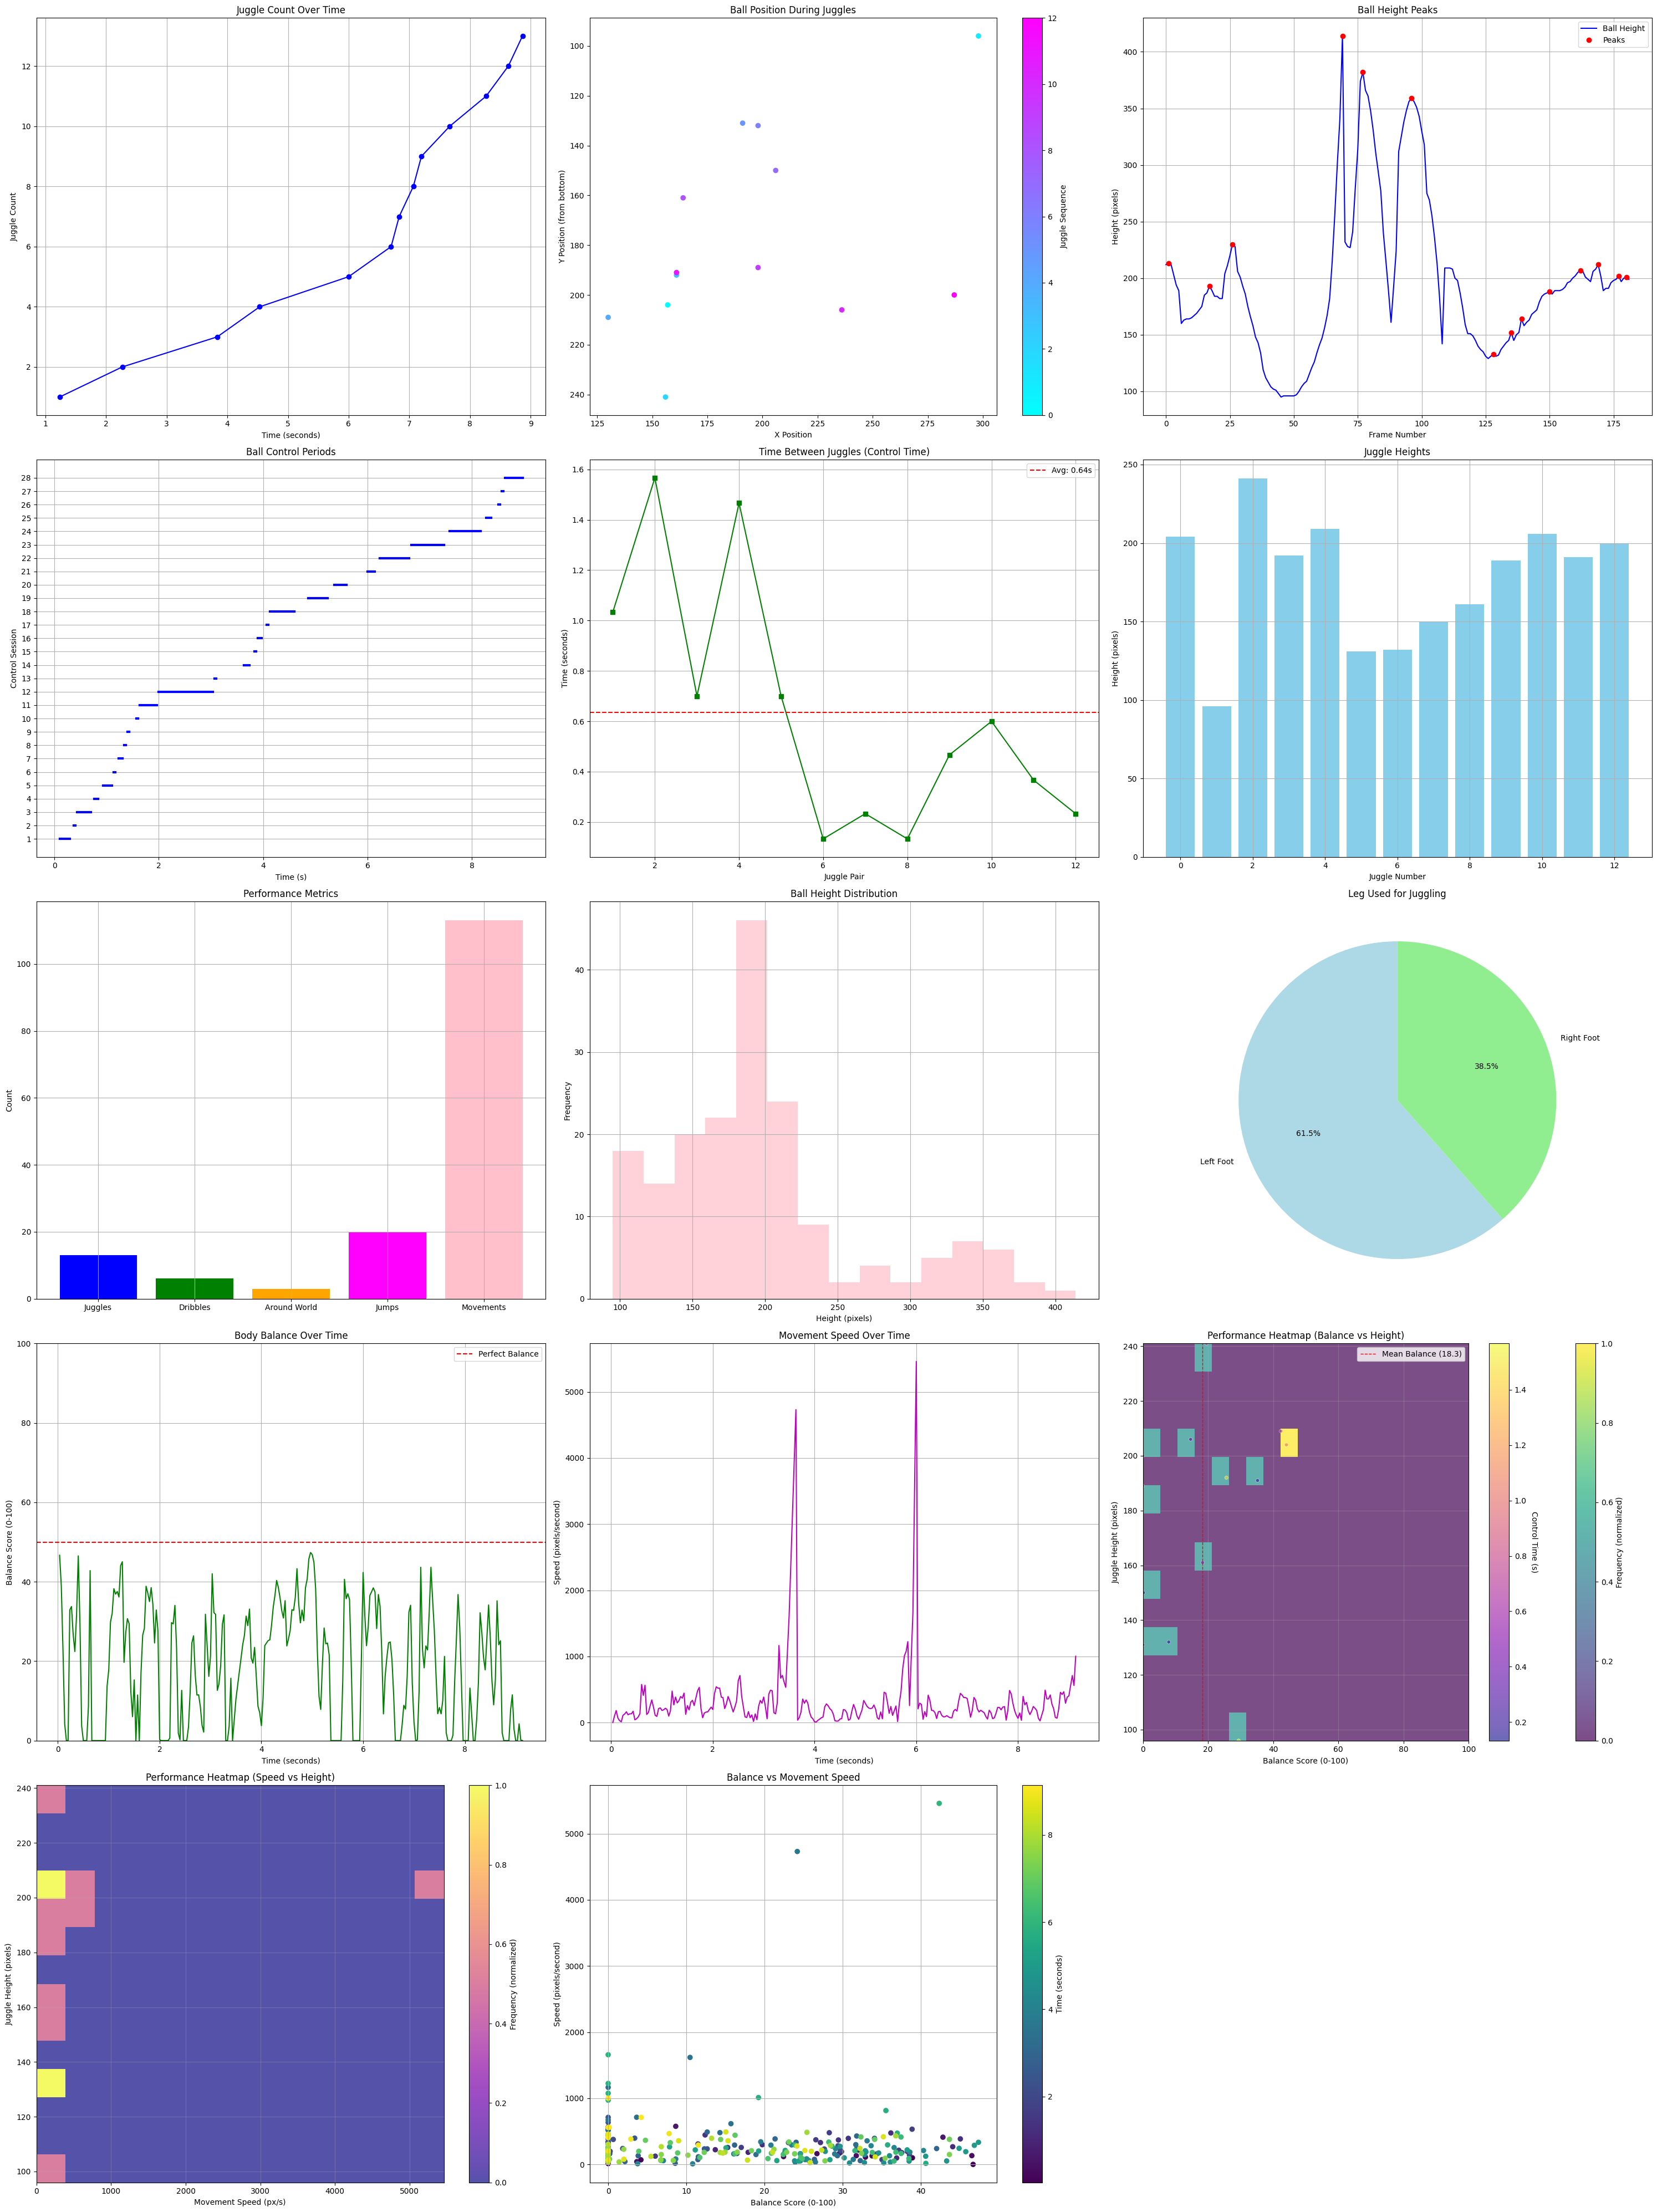

In [4]:

# Final visualizations
if juggle_data:
    times, x_pos, y_pos = zip(*juggle_data)
    normalized_heights = [frame_height - y for y in y_pos]
    
    posture_times, balance_scores, movement_speeds = zip(*posture_data) if posture_data else ([], [], [])

    plt.figure(figsize=(30, 40))

    # 1. Juggles over time
    plt.subplot(5, 3, 1)
    plt.plot(times, range(1, len(times)+1), 'b-o')
    plt.title('Juggle Count Over Time')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Juggle Count')
    plt.grid(True)

    # 2. Ball position during juggles
    plt.subplot(5, 3, 2)
    plt.scatter(x_pos, normalized_heights, c=range(len(x_pos)), cmap='cool')
    plt.colorbar(label='Juggle Sequence')
    plt.title('Ball Position During Juggles')
    plt.xlabel('X Position')
    plt.ylabel('Y Position (from bottom)')
    plt.gca().invert_yaxis()

    # 3. Ball trajectory peaks detection
    plt.subplot(5, 3, 3)
    if len(ball_height_history) > 1:
        peaks = [i for i in range(1, len(ball_height_history)-1) 
                if ball_height_history[i-1] < ball_height_history[i] > ball_height_history[i+1]]
        plt.plot(ball_height_history, 'b-', label='Ball Height')
        plt.plot(peaks, [ball_height_history[i] for i in peaks], 'ro', label='Peaks')
        plt.title('Ball Height Peaks')
        plt.xlabel('Frame Number')
        plt.ylabel('Height (pixels)')
        plt.legend()
        plt.grid(True)

    # 4. Ball control periods
    plt.subplot(5, 3, 4)
    for i, (start, end) in enumerate(control_periods):
        plt.plot([start, end], [i+1, i+1], 'b-', linewidth=3)
    plt.title('Ball Control Periods')
    plt.xlabel('Time (s)')
    plt.ylabel('Control Session')
    plt.yticks(range(1, len(control_periods)+1))
    plt.grid(True)

    # 5. Time between juggles
    plt.subplot(5, 3, 5)
    if len(control_times) > 0:
        plt.plot(range(1, len(control_times)+1), control_times, 'g-s')
        plt.axhline(y=np.mean(control_times), color='r', linestyle='--',
                    label=f'Avg: {np.mean(control_times):.2f}s')
        plt.title('Time Between Juggles (Control Time)')
        plt.xlabel('Juggle Pair')
        plt.ylabel('Time (seconds)')
        plt.legend()
        plt.grid(True)

    # 6. Juggle heights
    plt.subplot(5, 3, 6)
    plt.bar(range(len(normalized_heights)), normalized_heights, color='skyblue')
    plt.title('Juggle Heights')
    plt.xlabel('Juggle Number')
    plt.ylabel('Height (pixels)')
    plt.grid(True)

    # 7. Performance metrics
    plt.subplot(5, 3, 7)
    metrics = ['Juggles', 'Dribbles', 'Around World', 'Jumps', 'Movements']
    values = [juggle_count, dribble_count, around_world_count, jump_count, movement_count]
    colors = ['blue', 'green', 'orange', 'magenta', 'pink']
    plt.bar(metrics, values, color=colors)
    plt.title('Performance Metrics')
    plt.ylabel('Count')
    plt.grid(True)

    # 8. Ball height distribution
    plt.subplot(5, 3, 8)
    plt.hist(ball_height_history, bins=15, color='pink', alpha=0.7)
    plt.title('Ball Height Distribution')
    plt.xlabel('Height (pixels)')
    plt.ylabel('Frequency')
    plt.grid(True)

    # 9. Leg used pie chart
    plt.subplot(5, 3, 9)
    plt.pie(leg_touches.values(), labels=['Left Foot', 'Right Foot'],
            autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightgreen'])
    plt.title('Leg Used for Juggling')

    # 10. Balance over time
    plt.subplot(5, 3, 10)
    if posture_data:
        plt.plot(posture_times, balance_scores, 'g-')
        plt.axhline(y=50, color='r', linestyle='--', label='Perfect Balance')
        plt.title('Body Balance Over Time')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Balance Score (0-100)')
        plt.ylim(0, 100)
        plt.legend()
        plt.grid(True)

    # 11. Movement speed over time
    plt.subplot(5, 3, 11)
    if posture_data:
        plt.plot(posture_times, movement_speeds, 'm-')
        plt.title('Movement Speed Over Time')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Speed (pixels/second)')
        plt.grid(True)

    # 12. Balance vs Performance - Heatmap version
    plt.subplot(5, 3, 12)
    if posture_data and juggle_data:
        aligned_balance = []
        aligned_control_times = []
        
        for juggle_time, height in zip(times, normalized_heights):
            idx = np.argmin(np.abs(np.array(posture_times) - juggle_time))
            aligned_balance.append(balance_scores[idx])
            if control_times:
                ctrl_idx = min(len(control_times)-1, len(aligned_balance)-1)
                aligned_control_times.append(control_times[ctrl_idx])
        
        balance_bins = np.linspace(0, 100, 20)
        height_bins = np.linspace(min(normalized_heights), max(normalized_heights), 15)
        
        heatmap, xedges, yedges = np.histogram2d(
            aligned_balance,
            normalized_heights,
            bins=[balance_bins, height_bins]
        )
        
        if heatmap.max() > 0:
            heatmap = heatmap / heatmap.max()
        
        plt.imshow(
            heatmap.T, 
            origin='lower',
            aspect='auto',
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
            cmap='viridis',
            alpha=0.7
        )
        
        cbar = plt.colorbar(label='Frequency (normalized)')
        
        if aligned_control_times:
            plt.scatter(
                aligned_balance,
                normalized_heights,
                c=aligned_control_times,
                s=20,
                cmap='plasma',
                alpha=0.6,
                edgecolors='w',
                linewidths=0.5
            )
            cbar = plt.colorbar(label='Control Time (s)')
            cbar.set_label('Control Time (s)', rotation=270, labelpad=15)
        
        plt.title('Performance Heatmap (Balance vs Height)')
        plt.xlabel('Balance Score (0-100)')
        plt.ylabel('Juggle Height (pixels)')
        plt.grid(True, alpha=0.3)
        
        mean_balance = np.mean(aligned_balance)
        plt.axvline(mean_balance, color='r', linestyle='--', linewidth=1, label=f'Mean Balance ({mean_balance:.1f})')
        plt.legend()



    # 16. Performance Heatmap (Speed vs Height)
    plt.subplot(5, 3, 13)
    if posture_data and juggle_data:
        aligned_speeds = []
        
        for juggle_time, height in zip(times, normalized_heights):
            idx = np.argmin(np.abs(np.array(posture_times) - juggle_time))
            aligned_speeds.append(movement_speeds[idx])
        
        speed_bins = np.linspace(min(movement_speeds), max(movement_speeds), 15)
        height_bins = np.linspace(min(normalized_heights), max(normalized_heights), 15)
        
        heatmap, xedges, yedges = np.histogram2d(
            aligned_speeds,
            normalized_heights,
            bins=[speed_bins, height_bins]
        )
        
        if heatmap.max() > 0:
            heatmap = heatmap / heatmap.max()
        
        plt.imshow(
            heatmap.T, 
            origin='lower',
            aspect='auto',
            extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
            cmap='plasma',
            alpha=0.7
        )
        
        plt.colorbar(label='Frequency (normalized)')
        plt.title('Performance Heatmap (Speed vs Height)')
        plt.xlabel('Movement Speed (px/s)')
        plt.ylabel('Juggle Height (pixels)')
        plt.grid(True, alpha=0.3)

    # 15. NEW: Balance vs Speed
    plt.subplot(5, 3, 14)
    if posture_data:
        plt.scatter(balance_scores, movement_speeds, c=posture_times, cmap='viridis')
        plt.colorbar(label='Time (seconds)')
        plt.title('Balance vs Movement Speed')
        plt.xlabel('Balance Score (0-100)')
        plt.ylabel('Speed (pixels/second)')
        plt.grid(True)

    plt.tight_layout()
    plt.savefig('football_freestyle_analysis.png')
    plt.show()

In [5]:
# Print final statistics
print("\n➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖ ⛹🏻‍♀️ Final Statistics ⛹🏻‍♀️ ➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖")
print(f"⚽ Total Juggles: {juggle_count}")
print(f"⛹🏻 Total Dribbles: {dribble_count}")
print(f"🔄 Total Around the World: {around_world_count}")
print(f"🏃🏻‍♂️‍➡️ Total Jumps: {jump_count}")
print(f"🦵🏻 Left/Right Foot Usage: {leg_touches['left']}/{leg_touches['right']}")
if control_periods:
    avg_control_time = sum(end - start for start, end in control_periods) / len(control_periods)
    print(f"✅ Average Ball Control Time: {avg_control_time:.2f}s")
if juggle_data:
    avg_juggle_interval = sum(control_times) / len(control_times) if control_times else 0
    print(f"☑️ Average Juggle Interval: {avg_juggle_interval:.2f}s")

# Average speed 
if movement_speed_history:
    avg_speed = sum(movement_speed_history) / len(movement_speed_history)
    print(f"🏃🏻‍♂️ Average Movement Speed: {avg_speed:.2f} pixels/s")

# Average balance score
if balance_history:    
    avg_balance = sum(balance_history) / len(balance_history)
    print(f"⚖️ Average Balance Score: {avg_balance:.2f}/100")    

# Average height of the ball
if ball_height_history:
    avg_height = sum(ball_height_history) / len(ball_height_history)
    print(f"⚽ Average Ball Height: {avg_height:.2f} pixels")

# Average distance to floor
if last_floor_y is not None:
    avg_distance_to_floor = sum(abs(last_floor_y - y) for y in ball_height_history) / len(ball_height_history)
    print(f"🏠 Average Distance to Floor: {avg_distance_to_floor:.2f} pixels")   

# Average speed of the ball
if ball_velocity:
    avg_ball_speed = sum(ball_velocity) / len(ball_velocity)
    print(f"⚽ Average Ball Speed: {avg_ball_speed:.2f} pixels/s")

# Average height of the ball during juggles
if ball_height_history:
    avg_juggle_height = sum(ball_height_history) / len(ball_height_history)
    print(f"⚽ Average Juggle Height: {avg_juggle_height:.2f} pixels")



➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖ ⛹🏻‍♀️ Final Statistics ⛹🏻‍♀️ ➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖
⚽ Total Juggles: 13
⛹🏻 Total Dribbles: 6
🔄 Total Around the World: 3
🏃🏻‍♂️‍➡️ Total Jumps: 20
🦵🏻 Left/Right Foot Usage: 8/5
✅ Average Ball Control Time: 0.22s
☑️ Average Juggle Interval: 0.64s
🏃🏻‍♂️ Average Movement Speed: 297.93 pixels/s
⚖️ Average Balance Score: 18.45/100
⚽ Average Ball Height: 196.07 pixels
🏠 Average Distance to Floor: 352.87 pixels
⚽ Average Ball Speed: -1.00 pixels/s
⚽ Average Juggle Height: 196.07 pixels
